# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum, col, split, mean, first, lit
from pyspark.sql.functions import UserDefinedFunction as udf
from pyspark.sql.functions import broadcast

from pyspark.ml.feature import StandardScaler, VectorAssembler, HashingTF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier,LinearSVC, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import numpy as np
import pyspark.sql.functions as f
import datetime
import matplotlib as plt
import seaborn as sns

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Spark SQL Quiz") \
    .getOrCreate()

data = spark.read.json("mini_sparkify_event_data.json")
#user_log.createOrReplaceTempView("log_table")

In [4]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
data.show(vertical = True, n=5, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------
 artist        | Martha Tilston                                                                                                  
 auth          | Logged In                                                                                                       
 firstName     | Colin                                                                                                           
 gender        | M                                                                                                               
 itemInSession | 50                                                                                                              
 lastName      | Freeman                                                                                                         
 length        | 277.89016                                                                

In [6]:
print('The columns of dataframe are:',data.columns,'\n')

# Null values in each dataframe are
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show(vertical = True, truncate = False)

The columns of dataframe are: ['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId'] 

-RECORD 0------------
 artist        | 0   
 auth          | 0   
 firstName     | 0   
 gender        | 0   
 itemInSession | 0   
 lastName      | 0   
 length        | 0   
 level         | 0   
 location      | 0   
 method        | 0   
 page          | 0   
 registration  | 0   
 sessionId     | 0   
 song          | 0   
 status        | 0   
 ts            | 0   
 userAgent     | 0   
 userId        | 0   



In [7]:
data.select("page").distinct().show(truncate = False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
+-------------------------+
only showing top 20 rows



We will take Cancellation Confirmation as churn and rest as non-churners.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

**Dataset Description**

In [8]:
# Churn is a label for user who cancelled
# Define a flag function
flag_cancelation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
data = data.withColumn("churn", flag_cancelation_event("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
data = data.withColumn("churn", Fsum("churn").over(windowval))


print('The total number of churners are:', data.agg(Fsum("churn")).collect()[0][0])
print('The total number of churners are:', data.agg(Fsum("churn")).collect()[0][0])

The total number of churners are: 44864
The total number of churners are: 44864


In [9]:
#data.filter(data["churn"] == 1).select("userId").dropDuplicates().count()
data.select('userId', 'churn').distinct().agg(Fsum("churn")).collect()[0][0]

52

In [10]:
# understanding how a user activity is recorded in dataset
#data[['userId', 'page','churn']].filter(data['churn'] == 1).show(100) 

In [11]:
def missing_recs(df, col):

    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == "")).count()


print("\nColumns in data are:\n",data.columns)

print("\n[missing values]\n")
for col in data.columns:
    missing_count = missing_recs(data, col)
    if missing_count > 0:
        print("{}: {}".format(col, missing_count))


#df = data.filter(data.userId != '').collect()
#data.agg(Fsum("page")).collect()[0][0]


Columns in data are:
 ['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId', 'churn']

[missing values]

artist: 58392
firstName: 8346
gender: 8346
lastName: 8346
length: 58392
location: 8346
registration: 8346
song: 58392
userAgent: 8346
userId: 8346


In [12]:
print('Total number of rows in data are:', data.count())
print('Length of data after dropping blank userId:', data[data['userId'] != ''].count())
data = data[data['userId'] != '']

Total number of rows in data are: 286500
Length of data after dropping blank userId: 278154


In [13]:
stat_df = spark.createDataFrame(data.dropDuplicates(['userId']).collect()) # A way to convert list to dataframe

**Customer churn by genders**

In [14]:
#data.filter(data['page'] == 'Cancellation Confirmation').show()
# Null values in each columns are given y below code.
#print(data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()
#data = data.toPandas()
#stat_df = spark.createDataFrame(data.dropDuplicates(['userId']).collect())

stat_df1 = stat_df[['gender', 'churn']]

print('The avg churn rate of females is:', stat_df1.groupby(['gender']).mean().collect()[0][1]*100)
print('The avg churn rate of males is:', stat_df1.groupby(['gender']).mean().collect()[1][1]*100)

The avg churn rate of females is: 19.230769230769234
The avg churn rate of males is: 26.446280991735538


The males seem to cancel more than females but the difference between both the genders does not seem to be huge and thus is not worth of attention for further dwelling.

**Top 5 artists for churning**

In [15]:
# Viewing top 5 cancellations by artist
stat_df1 = stat_df[['artist', 'churn']]
stat_df1.groupBy(['artist']).sum().orderBy('sum(churn)', ascending = False).collect()[:5]

[Row(artist=None, sum(churn)=27),
 Row(artist='Orenda Fink', sum(churn)=1),
 Row(artist='P!nk', sum(churn)=1),
 Row(artist='P.O.D.', sum(churn)=1),
 Row(artist='Tasavallan Presidentti', sum(churn)=1)]

Thus it seems like more than 50% cancellations have occured for songs with no artist

**Level at which the customers churned**

In [16]:
stat_df1 = stat_df[['level', 'churn']]
print('proportion of users that chruned from free subscirption', stat_df1.groupBy(['level']).mean().collect()[0][1]*100)
print('proportion of users that chruned from paid subscirption',stat_df1.groupBy(['level']).mean().collect()[1][1]*100)

proportion of users that chruned from free subscirption 24.858757062146893
proportion of users that chruned from paid subscirption 16.666666666666664


This indicates that proportion of free users tend to cancel much more than the people who are paid users.

**Top 10 states with highest churn**

In [17]:
stat_df1 = stat_df[['location', 'churn']]

stat_df1 = stat_df1.withColumn('state', split(stat_df['location'], ',').getItem(1))
stat_df1 = stat_df1.drop('location')

print("Viewing top 10 states to churn:\n")
stat_df1.groupBy(['state']).sum().filter("sum(churn)> 0").orderBy('sum(churn)', ascending = False).show(10)

Viewing top 10 states to churn:

+---------+----------+
|    state|sum(churn)|
+---------+----------+
|       CA|         6|
| NY-NJ-PA|         5|
|       MI|         3|
|       TX|         3|
|       FL|         3|
|       MS|         2|
|       OH|         2|
|       AL|         2|
|       WA|         2|
|       AZ|         2|
+---------+----------+
only showing top 10 rows



Thus, the customers that mostly churned were from California, New York - New Jersey and Phili, Michigan, Texas and Florida. It is hard to assume what might be common in these states. But, for simplicity it seems like these locations are either having prominent cities or places in them overall. Especially it stands true for CA which is at the helm of churn by states.

In [18]:
#def cal_users(df, col):
#    mylst = df[[str(col)]].collect()
#    numlst = []
#    for i in mylst:
#        numlst.append(i[0])
#    total = df.select(Fsum(col)).collect()[0][0]    
#    lst = [i*100/total for i in numlst]
#    return lst

**Time Analysis:**

In [19]:
# User defined functions to get hour, day, month, and weekday of cancellation

get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)

# Source https://stackoverflow.com/questions/38928919/how-to-get-the-weekday-from-day-of-month-using-pyspark
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [20]:
# Adding columns to the dataframe
funcs = {'hour':get_hour, 'day':get_day, 'month':get_month, 'week_day':get_weekday}
for label, func in funcs.items():
    data = data.withColumn(label, func(data.ts))
    print(f'Column {label} added successfully.')

# to help in better plotting and visuals
dfp = data.toPandas()

Column hour added successfully.
Column day added successfully.
Column month added successfully.
Column week_day added successfully.


In [21]:
def get_series(col, churn, normalize=False):
    ''' 
    Get a series either of churn users or existing users
    THe function can normalize the series and return a percent value
    col: {str} the column to plot (hour, month, day, week_day)
    churn: {int} 0 or 1
    normalize: {bool} T/F, Default is False
    return a sorted pandas series
    '''
    ser1 = dfp[dfp.churn == churn].groupby([col])['userId'].count()
    try:
        ser1.index = ser1.index.astype(int)
    except:
        pass
    if normalize:
        ser1=ser1/ser1.sum()*100
    return ser1.sort_index()

In [22]:
def draw_time(col, normalize=True, figsize=(16,4), title=None, label_rotation=0):
    '''
    Draw a bar plot for churn and existing users based on 
         a specific column (hour, month, day, week_day)
         
    normalize: {bool} T/F, Default is True
    figsize: {tuple} the plot size, default is (16,4)
    title: descriptive title part
    Returns: None
    '''
    df_time = pd.DataFrame({'Cancelled': get_series(col, 1, normalize),
                            'Active users':get_series(col, 0, normalize)})
    ax = df_time.plot(kind='bar', figsize=figsize);
    ax.set_ylabel('Percent of users')
    if title is None:
        title = col
    ax.set_ylabel(f'Percent of users')
    #print(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=label_rotation)
    ax.set_title(f'Percent of users took action per {title}') 
    return ax

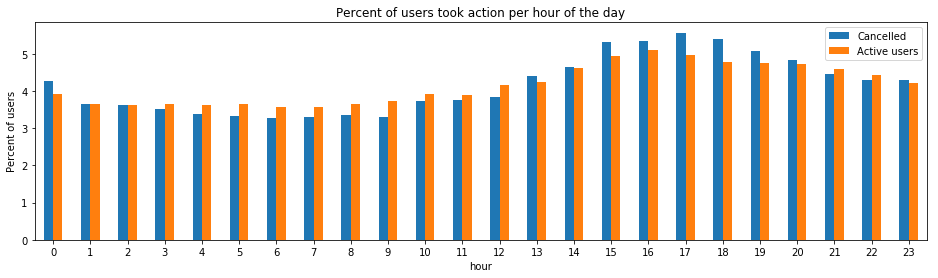

In [23]:
draw_time('hour', title='hour of the day');

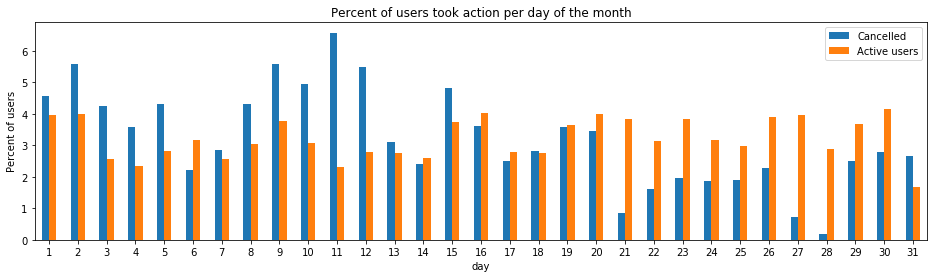

In [24]:
draw_time('day', title='day of the month');

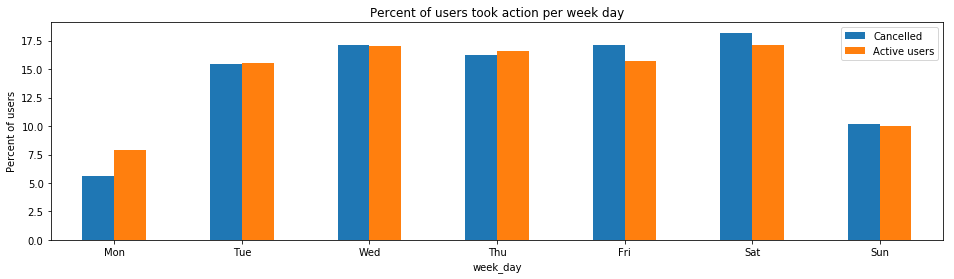

In [25]:
ax = draw_time('week_day', title='week day')
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0);

**Lifetime Since registration**

In [26]:
from pyspark.sql.functions import sum as Fsum, col, split, mean, first, lit

stat_df = data \
    .select('userId','registration','ts','churn') \
    .withColumn('lifetime',(data.ts-data.registration)) \
    .groupBy('userId','churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

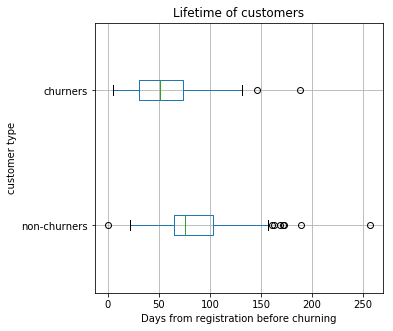

In [27]:
ax =stat_df.boxplot(column='lifetime', by='churn', figsize=(5,5), vert = False)#kind='box', ));
ax.set_xlabel('Days from registration before churning')
labels = [item.get_text() for item in ax.get_yticklabels()]
labels = ['non-churners','churners']
ax.set_yticklabels(labels)
ax.get_figure().suptitle("")
ax.set_title('Lifetime of customers')
ax.set_ylabel('customer type');

This plot depicts that churners had less experience with the music features of our product than the one that did not churn. Hence we can suggest longer period of free trials or also send out gentle emails for suggestion of longer stay with product before confirming cancellations.

In [28]:
stat_df = data.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
stat_df = stat_df.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

**Churn and non-churn density patterns between genders**

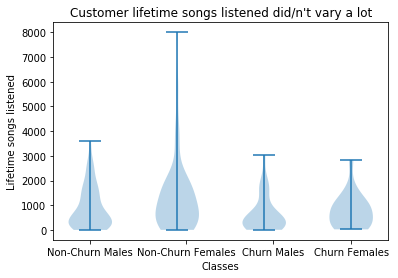

In [29]:
fig, ax = plt.pyplot.subplots()
ax = plt.pyplot.violinplot(dataset=[stat_df[(stat_df.churn == 0) & (stat_df.gender == 'M')]["NextSong"].values,
                                    stat_df[(stat_df.churn == 0) & (stat_df.gender == 'F')]["NextSong"].values,
                                    stat_df[(stat_df.churn == 1) & (stat_df.gender == 'M')]["NextSong"].values,
                                    stat_df[(stat_df.churn == 1) & (stat_df.gender == 'F')]["NextSong"].values
                                   ])
plt.pyplot.xticks([1,2.1,3.1,4],['Non-Churn Males','Non-Churn Females','Churn Males','Churn Females'])
plt.pyplot.xlabel('Classes')
plt.pyplot.ylabel('Lifetime songs listened')
plt.pyplot.title("Customer lifetime songs listened did/n't vary a lot")
plt.pyplot.show()

The lifetime songs listened by both males and females in churn and non-churn group did vary but not for two genders within the same group

**Number of songs played per session**

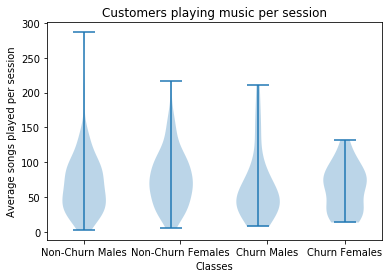

In [30]:
stat_df = data.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

fig, ax = plt.pyplot.subplots()
ax = plt.pyplot.violinplot(dataset=[stat_df[(stat_df.churn == 0) & (stat_df.gender == 'M')]["avg_songs_played"].values,
                                    stat_df[(stat_df.churn == 0) & (stat_df.gender == 'F')]["avg_songs_played"].values,
                                    stat_df[(stat_df.churn == 1) & (stat_df.gender == 'M')]["avg_songs_played"].values,
                                    stat_df[(stat_df.churn == 1) & (stat_df.gender == 'F')]["avg_songs_played"].values,
                                    ])
plt.pyplot.xticks([1,2.1,3.1,4],['Non-Churn Males','Non-Churn Females','Churn Males','Churn Females'])
plt.pyplot.xlabel('Classes')
plt.pyplot.ylabel('Average songs played per session')
plt.pyplot.title("Customers playing music per session")
plt.pyplot.show()

Both the churning and non-churning males had played more songs per session than females. Nevertheless, overall the churning members played less songs than the ones that did not.

**Pages visited by churned and non-churned customers**

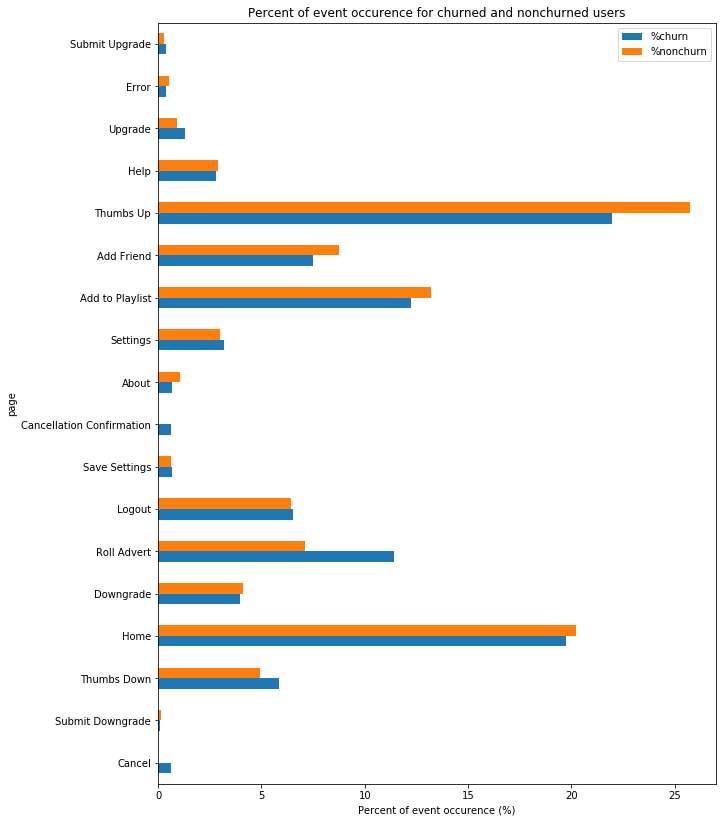

In [31]:
''' Understanding difference of activites between churned and active users to understand what went wrong 
with churned users better '''

# Creating records of Churned users
users_1 = data[data['churn'] == 1][['userId','page']].groupBy(['page']).agg(
    count('userId')).filter(data['page'] != 'NextSong')

users_1 = users_1.select(f.col('page'), 
                         (f.col('count(userId)')/users_1.select(Fsum('count(userId)')).collect()[0][0])*100)                        

users_1 = users_1.withColumnRenamed("((count(userId) / 8470) * 100)", "%churn")


# Creating records for Active Users
users_0 = data[data['churn'] == 0][['userId','page']].groupBy(['page']).agg(
    count('userId')).filter(data['page'] != 'NextSong')

users_0 = users_0.select(f.col('page'), 
                         (f.col('count(userId)')/users_0.select(Fsum('count(userId)')).collect()[0][0])*100)                        

users_0 = users_0.withColumnRenamed("((count(userId) / 41576) * 100)", "%nonchurn")

# Plotting percentage of churned users besides active users
stat_df = users_1.join(users_0, "page",'left_outer')
stat_df = stat_df.toPandas()
stat_df = stat_df.set_index(stat_df.columns[0])

ax = stat_df.plot(kind='barh', figsize=(10,14));
ax.set_xlabel('Percent of event occurence (%)')
ax.set_title('Percent of event occurence for churned and nonchurned users');

The stark differences between thumbs up for churners and non-churned users shows that churners were heavily disappointed with songs that they liked or probably even the audio quality of them.This is also supported with the bar of "Add friend" and "Add to Playlist" which is much higher for non-churners as compared to churners showing the likeness of non-churners being much higher than the users that churned.

The above explanation is also supplemented by seeing the "Thumbs down" bar higher for users who churned as compared for the ones that did not churned. The churners "Roll Advertisement" much larger as compared to ones that did not cancel. This too supports the claim that churners were highly dissapointed with song quality or collection and we should focus on feedback from them to improve the drawbacks.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

We have seen the difference in churners and non-churners since time of registry. Hence we shall consider making this feature to draw the user's engagement and likelihood.

In [32]:
# Time since registration
feat_1 = data \
    .select('userId','registration','ts') \
    .withColumn('lifetime',(data.ts-data.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
feat_1.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



The overall songs listened by churners was less than the ones listened by non-churners. Therefore second feature will depict the same

In [33]:
# Total songs listened
feat_2 = data \
    .select('userID','song') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_songs')
feat_2.describe().show()

+-------+------------------+-----------------+
|summary|            userID|      total_songs|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



Now let the third feature make about thumbs up and fourth be of thumbs down because we saw in bar graph above the stark difference these two features had between churners and non-churners.

In [34]:
# Number of Thumbs-Up/Down
feat_3 = data \
    .select('userID','page') \
    .where(data.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_up') 
feat_3.describe().show()

feat_4 = data \
    .select('userID','page') \
    .where(data.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_down')
feat_4.describe().show()

+-------+------------------+-----------------+
|summary|            userID|     num_thumb_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+

+-------+------------------+------------------+
|summary|            userID|    num_thumb_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



Number of songs listened per session were less for churners than non-churners and churners did add less songs to their playlist (as seen from bar graph). Hence, we will rely on this study to make our fifth feature as number of songs added to playlist

In [35]:
# Number of songs added to playlist
feat_5 = data \
    .select('userID','page') \
    .where(data.page == 'Add to Playlist') \
    .groupBy('userID')\
    .count() \
    .withColumnRenamed('count', 'add_to_playlist')
feat_5.describe().show()

+-------+------------------+-----------------+
|summary|            userID|  add_to_playlist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



From bar graph we also clearly see that friends added by non-churners were more than churners. Hence we would consider this to be our sixth feature

In [36]:
# Number of friends added
feat_6 = data \
    .select('userID','page') \
    .where(data.page == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_friend') 
feat_6.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



Total number of songs listened by customers in lifetime were way more for non-churners than the churners. Hence, in time instrospection we shall consider longetivity of listening to songs.

In [37]:
# Total length of listening
feat_7 = data \
    .select('userID','length') \
    .groupBy('userID') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listen_time')
feat_7.describe().show()

+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



Density of songs listened were higher for non-churners than churners. Hence average songs listened per session becomes our eighth feature.

In [38]:
# Number of songs listened per session
feat_8 = data.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avg_songs_played')
feat_8.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



We saw that proprtion of females churned were less than males. Hence we will include this as ninth feature.

In [39]:
# Gender
feat_9 = data \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
feat_9.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In the start we saw that there were some artists for which churning occured more than others. Hence, including number of artists listened to as our tenth feature.

In [40]:
# Number of artists listened
feat_10 = data \
    .filter(data.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "artist_count")
feat_10.describe().show()

+-------+------------------+-----------------+
|summary|            userId|     artist_count|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630802|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



Churn and non-churn label

In [41]:
# Churn label
label = data \
    .select('userId', col('churn').alias('label')) \
    .dropDuplicates()
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



Preparing our final dataframe to be used in modelling

In [42]:
data = feat_1.join(feat_2,'userID','outer') \
    .join(feat_3,'userID','outer') \
    .join(feat_4,'userID','outer') \
    .join(feat_5,'userID','outer') \
    .join(feat_6,'userID','outer') \
    .join(feat_7,'userID','outer') \
    .join(feat_8,'userID','outer') \
    .join(feat_9,'userID','outer') \
    .join(feat_10,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

data.show(5)

+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+
|          lifetime|total_songs|num_thumb_up|num_thumb_down|add_to_playlist|add_friend|       listen_time|  avg_songs_played|gender|artist_count|label|
+------------------+-----------+------------+--------------+---------------+----------+------------------+------------------+------+------------+-----+
|  55.6436574074074|        381|          17|             5|              7|         4| 66940.89735000003|39.285714285714285|     1|         252|    0|
| 70.07462962962963|        474|          21|             6|              8|         4| 94008.87593999993|              64.5|     0|         339|    0|
| 71.31688657407408|         11|           0|             0|              0|         0|2089.1131000000005|               8.0|     0|           8|    1|
|131.55591435185184|       4825|         171|            41|            118|        74|1

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

First we have to vectorize and scale the features to remove any present bias and introduce normalization. This is done to ensure that one feature doesn't domainate the entire model.Thus, we will we standardize the features by taking off the mean and divided by the standard deviation of each feature.

In [43]:
# Vector assembler
cols = ["lifetime","total_songs","num_thumb_up",'num_thumb_down','add_to_playlist',
        'add_friend','listen_time','avg_songs_played','gender','artist_count']

assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(data)

# standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

We need a stratified samplifing as our label is too much skewed. We would make two splits to test. One of validation set and other of test set.

In [44]:
# train test split
train, rest = data.randomSplit([0.7, 0.3], seed=42)
validation, test = rest.randomSplit([0.6, 0.4], seed=42)

**Base Models to decide approach for unbalanced dataset**

We will check for churned as well as non-churn. Because, the dataset is uneven. The churners are far less than non-churners.Hence we will create two base models for both churners as well as non-churners. Thus making 2 base models for label churn = 1 (churned) and churn = 0 (non-churned)

In [45]:
results_base_all_1 = test.withColumn('prediction', lit(1.0))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.25
F1 Score:0.10000000000000002


In [46]:
results_base_all_0 = test.withColumn('prediction', lit(0.0))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.75
F1 Score:0.6428571428571428


**Gradient Boosted Trees**

In [47]:
# initialize classifier
GradBoostTree = GBTClassifier(maxIter=5,seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_GradBoostTree = CrossValidator(estimator=GradBoostTree,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=5)

cvModel_GradBoostTree = crossval_GradBoostTree.fit(train)
cvModel_GradBoostTree.avgMetrics

results_GradBoostTree = cvModel_GradBoostTree.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_GradBoostTree, {evaluator.metricName: "accuracy"})))
print('F1 Score:{}'.format(evaluator.evaluate(results_GradBoostTree, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.7857142857142857
F1 Score:0.7542857142857142


**Logistic Regression**

In [48]:
# initialize classifier
lr = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics

results_lr = cvModel_lr.transform(validation)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.8571428571428571
F-1 Score:0.7912087912087912


Out of both the tested models, I suppose that LogR performed much at par than Gradient Boosted Tree. Therefore, proceeding with parameter tuning for LogR and using it as our model for further steps.

I am more focussed on F1 score as its a paramter to understand the swing between precision and recall. For the purpose of our model, we should be focussing on higher precision since we want to make sure that the likely churning customers should be detected and even if it increases the likelihood of falsely turning some non-churning customers as churning, it wont harm because here we are focussing on people who should not leave our business rather than seeing someone who's life is at stake like in healthcare.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

**Hyperparameter Tuning**

In [55]:
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
lr = LogisticRegression()
paramGrid = ParamGridBuilder().addGrid(lr.maxIter, [10,12])\
                                .addGrid(lr.regParam, [0,0.1]) \
                                .addGrid(lr.elasticNetParam, [0.001,0.01]) \
                                .build()
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, \
                        evaluator=f1_evaluator, numFolds=3)

In [56]:
lrModel = lr_cv.fit(train)
bestModel = lrModel.bestModel

**Best Model**

In [57]:
results_final = bestModel.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.8125
F-1 Score:0.782204020848846


**Feature Importance of LogR Model**

I have put to use the coefficients (beta) of features to understand the feature importance of our LogR model. 

In [ ]:
feat_imp = abs(bestModel.coefficients.values)
cols = ["lifetime", "TotalSongs", "Thumbsup", \
          'ThumbsDown','PlaylistAdd','FriendAdd','ListeningTime','AvgSongsPlay', \
        'Gender', 'NumofArtists']
y_pos = np.arange(len(cols))
 
plt.pyplot.barh(y_pos, feat_imp, align='center')
plt.pyplot.yticks(y_pos,cols, rotation = 45)
plt.pyplot.xlabel('Importance Score')
plt.pyplot.title('Feature Importances');
plt.pyplot.tight_layout()
plt.pyplot.show()

# Conclusion

<u>**Feature Importance**</u>:

As we clearly see that the lifetime is the greatest important feature coupled with thumbs down and friends referred. This makes top 3 important features. We can easily say that the person about to churn did not like the quality of songs either by his/her liking or the audio quality. Such people did not referred friends which was very obvious. Thought the length of using service seems to dominate the behaviour to churn, it could be biased. Because, the churned customers used the product for shorter time. Hence we can consider some other transformations to mitigate this bias.

<u> **I have performed following actions on my dataset**</u>:

1.) Dropped rows with no userId.

2.) converted timestamp to a human readable format.

3.) converted categorical and other non-numeric columns to numeric using dummy variables or other methods. 

<u>**Modelling actions**</u>:

1.) Feature engineering yielded 10 features. 

2.) 2 models were used, Gradient Boosted Tree and Logistic Regression in which the later won. 

3.) For tuning the model, cross validation and grid search were used. 

<u>Results achieved</u>:

1.) 81% accuracy and 78% F1 score on test set.

2.) Thus, the LogR model performed multiple times better than our baseline models.

<u>Drawbacks and Way forward</u>:

1.) We can re-use lot of part of the above code in actual work environment. The notebook sets a crude yet very close mirroring to what one shall encounter in field experience when it comes to not only coding but also in areas of customer churn.

2.) Although it was a great learning experience overall, the few points can still be improved within this notebook which are; using multiple models before jumping to final conclusion, SCRUM calls with SMEs to understand the direction and domain perspective on each feature, rigorous test cases to make sure model withstands changing marketing sentiments and styles of customer usage methods, etc.